## Imports

In [1]:
!pip install -q lightning onnxruntime torchsummary

In [2]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import wandb

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Model Settings

In [4]:
### SETTINGS
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 16
NUM_EPOCHS = 20

# Architecture
GROWTH_RATE = 32
COMPRESSION_FACTOR = 0.5
NUM_CLASSES = 24

# Other
DEVICE = "cuda:0"
GRAYSCALE = False

In [31]:
### DATASETS
DATA_PATH = ''
TRAIN_PATH = DATA_PATH + 'train_data'
TEST_PATH = DATA_PATH + 'test_data'

classes = list()
for i in range (1, 25):
    classes.append(str(i))

In [19]:
print(classes)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']


In [9]:
def plot_pie(counts): 
    plt.figure(figsize=(8, 8))
    plt.pie(
        list(counts.values()), 
        labels=list(counts.keys()), 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=plt.cm.Paired.colors
    )
    plt.title("Phân bố các trường dữ liệu")
    plt.show()

In [15]:
import os 

def count_data(path: str): 
    classes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
    
    counts = {}

    for root, dirs, files in os.walk(path): 
        name = str(root.split("/")[-1]) 
        
        if files != [] and name in classes: 
            counts[name] = len(files)
    return counts

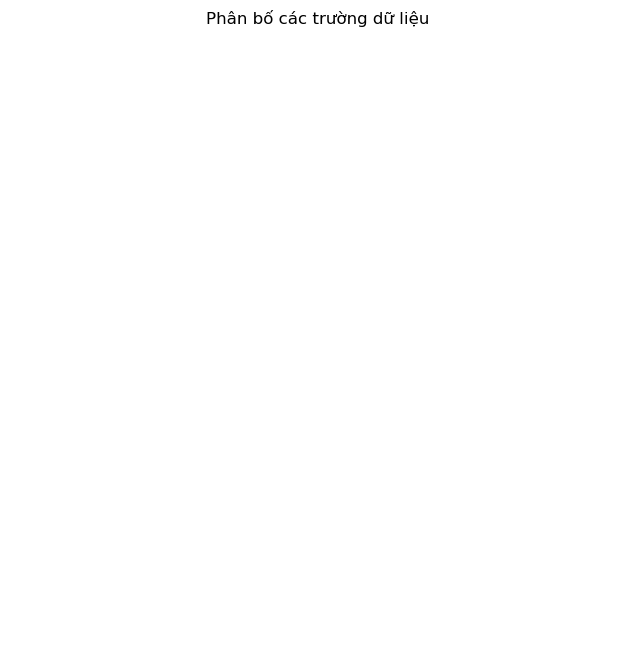

In [32]:
count_training = count_data(TRAIN_PATH)
plot_pie(count_training)

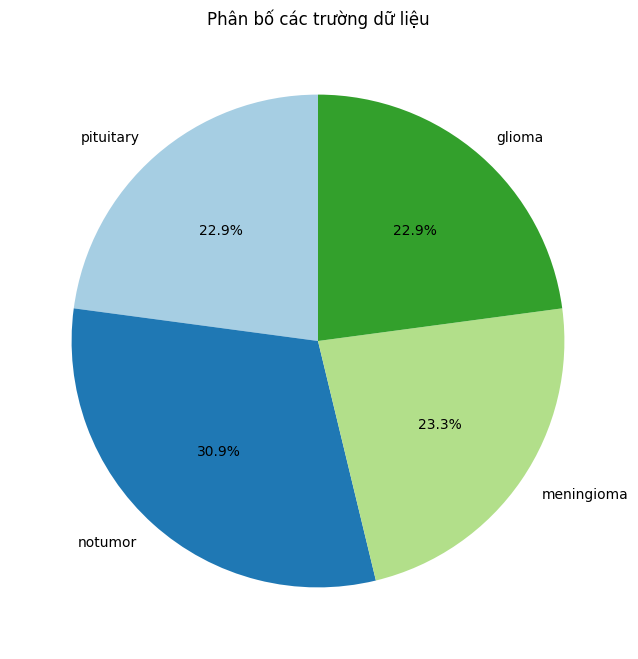

In [9]:
count_testing = count_data(TEST_PATH)
plot_pie(count_testing)

In [10]:
from PIL import Image

def get_image_sizes(folder_path):
    image_sizes = []  
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        width, height = img.size
                        image_sizes.append((width, height))
                except Exception as e:
                    print(f"Lỗi đọc ảnh {file_path}: {e}")
    return image_sizes

In [11]:
def plot_img_size(image_sizes, data_name): 
    widths, heights = zip(*image_sizes)  
    plt.figure(figsize=(8, 6))
    plt.scatter(widths, heights, alpha=0.6, edgecolor='k')
    plt.title(f'Kích thước ảnh (Width x Height) của {data_name}', fontsize=14)
    plt.xlabel('Chiều rộng (Width)', fontsize=12)
    plt.ylabel('Chiều cao (Height)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

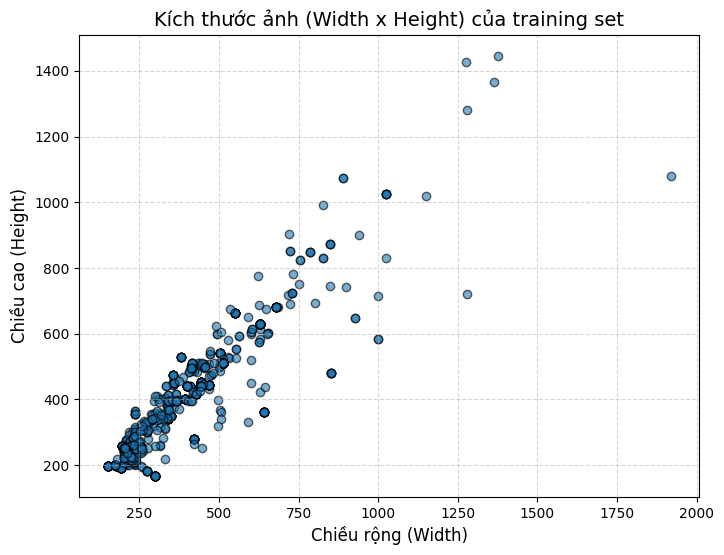

In [12]:
training_image_sizes = get_image_sizes(TRAIN_PATH)
plot_img_size(training_image_sizes, "training set")

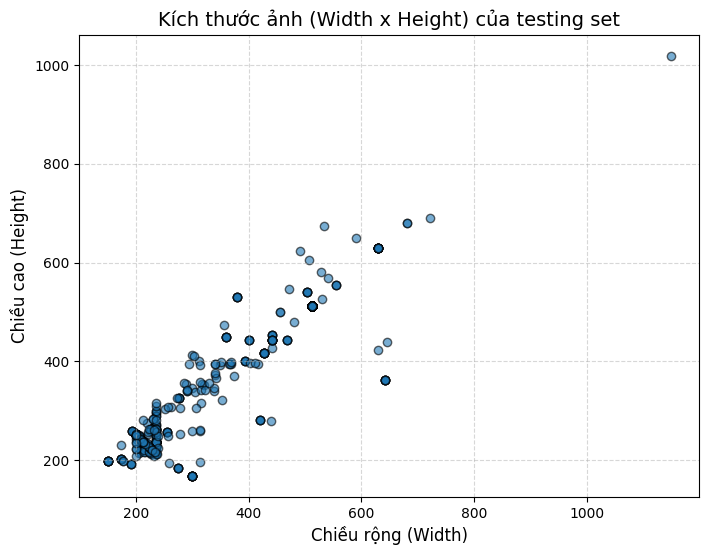

In [13]:
testing_image_sizes = get_image_sizes(TEST_PATH)
plot_img_size(testing_image_sizes, "testing set")

In [14]:
import random

def get_category_images(folder_path):
    category_images = {}
    for root, _, files in os.walk(folder_path):
        category = os.path.basename(root)
        if category not in category_images:
            category_images[category] = []
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                category_images[category].append(os.path.join(root, file))
    return category_images

In [15]:
def plot_random_images(category_images):
    selected_images = {}

    for category, images in category_images.items():
        if images: 
            selected_images[category] = random.choice(images)
    
    plt.figure(figsize=(12, 8))
    for i, (category, image_path) in enumerate(selected_images.items(), start=1):
        print(image_path)
        try:
            img = Image.open(image_path).convert('RGB')
            plt.subplot(2, 2, i)
            plt.imshow(img, )
            plt.title(category)
            plt.axis('off')
        except Exception as e:
            print(f"Không thể mở ảnh {image_path}: {e}")
    plt.tight_layout()
    plt.show()

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1383.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0528.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-me_1304.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-gl_0132.jpg


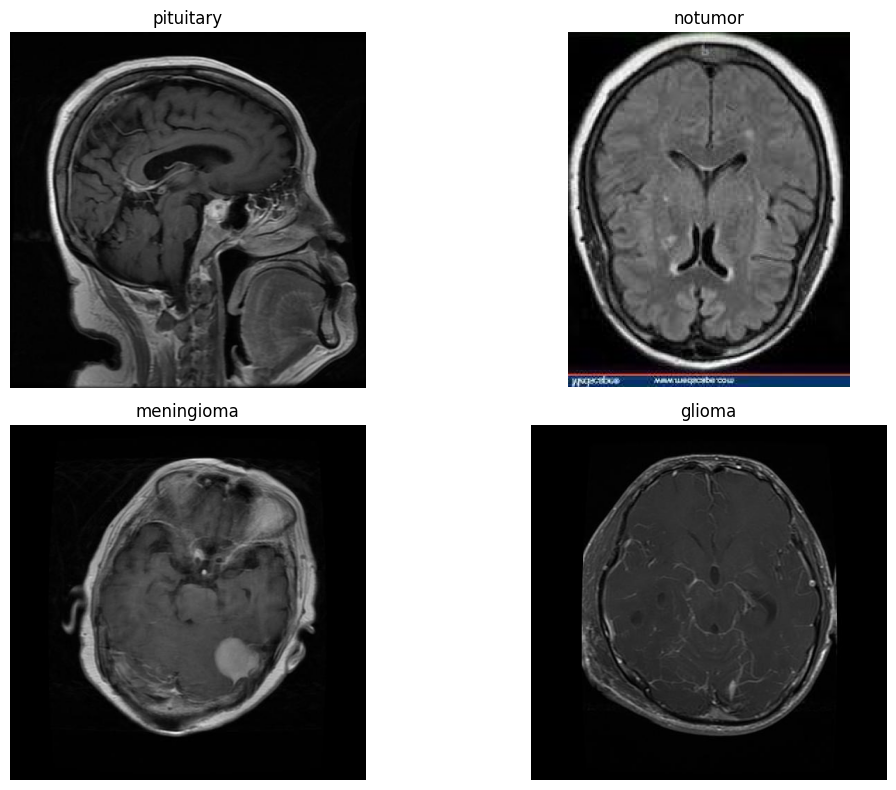

In [16]:
category_images = get_category_images(TRAIN_PATH)
plot_random_images(category_images)

In [17]:
def transform_data_to_dict(folder_path):
    image_dict = {} 
    index = 0

    for root, _, files in os.walk(folder_path):
        label = os.path.basename(root)
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                file_path = os.path.join(root, file)
                image_dict[index] = {'path': file_path, 'label': label}
                index += 1
    return image_dict

In [18]:
train_dict = transform_data_to_dict(TRAIN_PATH)
test_dict = transform_data_to_dict(TEST_PATH)

In [19]:
len(train_dict)

5712

In [20]:
len(test_dict)

1311

In [21]:
# visualize 
from torch.utils.data import Dataset, DataLoader

class BrainTumourDataset(Dataset): 

    def __init__(self, data_dir: str, transform = None): 
        self.data_dict = transform_data_to_dict(data_dir)
        self.transform = transform 
        self.labels =  ['glioma', 'meningioma', 'notumor', 'pituitary']
        

    def __getitem__(self, idx):
        datapoint = self.data_dict[idx]
        path = datapoint['path']
        label = self.labels.index(datapoint['label']) 

        img = Image.open(path).convert('RGB')
        if self.transform : img = self.transform(img)
        return img, label
            
        
    def __len__(self): 
        return len(self.data_dict)

In [22]:
from torchvision import transforms 

data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ColorJitter(),
                                     transforms.Resize((224,224))])

In [23]:
# define data loader 
import lightning as pl 


class BrainTumorDatamodule(pl.LightningDataModule): 

    def __init__(self, train_dir: str, test_dir: str, transform):
        self.train_dir = train_dir
        self.test_dir = test_dir 
        self.transform = transform 

    def setup(self, stage = None): 
        self.train_dataset = BrainTumourDataset(self.train_dir, self.transform)
        self.test_dataset = BrainTumourDataset(self.test_dir, self.transform)


    def train_dataloader(self, batch_size): 
        return DataLoader(self.train_dataset, shuffle=True, batch_size= batch_size, num_workers=4)

    def test_dataloader(self, batch_size): 
        return DataLoader(self.test_dataset, shuffle=True, batch_size= batch_size, num_workers=4)

In [24]:
batch_size = BATCH_SIZE

datamodule = BrainTumorDatamodule(TRAIN_PATH, TEST_PATH, data_transform)

datamodule.setup()

train_loader = datamodule.train_dataloader(batch_size)

test_loader = datamodule.test_dataloader(batch_size)

In [25]:
image_tensor = datamodule.train_dataset[0][0]
label =  datamodule.train_dataset.labels[datamodule.train_dataset[0][1]]

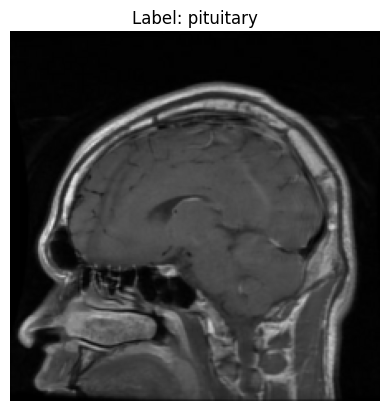

In [26]:
image = image_tensor.permute(1, 2, 0).numpy()

plt.imshow(image)
plt.axis('off')  
plt.title(f"Label: {label}")
plt.show()

In [27]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 16
Epoch: 2 | Batch index: 0 | Batch size: 16


In [28]:
### MODEL
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict



def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = drop_rate
        self.memory_efficient = memory_efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.memory_efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet121(nn.Module):
    def __init__(self, growth_rate=GROWTH_RATE, block_config=(6, 12, 24, 16),
                 num_init_featuremaps=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False,
                 compression_factor = COMPRESSION_FACTOR, grayscale=False):

        super(DenseNet121, self).__init__()

        # First convolution
        if grayscale:
            in_channels=1
        else:
            in_channels=3
        
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(in_channels=in_channels, out_channels=num_init_featuremaps,
                                kernel_size=7, stride=2,
                                padding=3, bias=False)), # bias is redundant when using batchnorm
            ('norm0', nn.BatchNorm2d(num_features=num_init_featuremaps)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_featuremaps
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=int(num_features * compression_factor))
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = int(num_features * compression_factor)

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        logits = self.classifier(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [29]:
torch.manual_seed(RANDOM_SEED)

model = DenseNet121(num_classes=NUM_CLASSES, grayscale=GRAYSCALE)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  
criterion = nn.CrossEntropyLoss().to(DEVICE)

In [30]:
from torchsummary import summary
print(summary(model, input_size=(3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
      BatchNorm2d-11           [-1, 96, 56, 56]             192
             ReLU-12           [-1, 96, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]          12,288
      BatchNorm2d-14          [-1, 128,

## Training

In [31]:
def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    model.eval()
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        assert predicted_labels.size() == targets.size()
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [32]:
start_time = time.time()

cost_list = []
train_acc_list = []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        cost_list.append(cost.item())
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        
        train_acc = compute_acc(model, train_loader, device=DEVICE)
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f}')

        train_acc_list.append(train_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/020 | Batch 000/357 | Cost: 1.3668
Epoch: 001/020 | Batch 120/357 | Cost: 0.7040
Epoch: 001/020 | Batch 240/357 | Cost: 0.6863
Epoch: 001/020
Train ACC: 70.73
Time elapsed: 1.57 min
Epoch: 002/020 | Batch 000/357 | Cost: 0.7950
Epoch: 002/020 | Batch 120/357 | Cost: 0.7787
Epoch: 002/020 | Batch 240/357 | Cost: 0.2649
Epoch: 002/020
Train ACC: 82.11
Time elapsed: 3.13 min
Epoch: 003/020 | Batch 000/357 | Cost: 0.5096
Epoch: 003/020 | Batch 120/357 | Cost: 0.8136
Epoch: 003/020 | Batch 240/357 | Cost: 0.9103
Epoch: 003/020
Train ACC: 46.76
Time elapsed: 4.69 min
Epoch: 004/020 | Batch 000/357 | Cost: 0.5289
Epoch: 004/020 | Batch 120/357 | Cost: 0.1998
Epoch: 004/020 | Batch 240/357 | Cost: 0.4038
Epoch: 004/020
Train ACC: 70.20
Time elapsed: 6.27 min
Epoch: 005/020 | Batch 000/357 | Cost: 0.4209
Epoch: 005/020 | Batch 120/357 | Cost: 0.1904
Epoch: 005/020 | Batch 240/357 | Cost: 0.4175
Epoch: 005/020
Train ACC: 88.41
Time elapsed: 7.83 min
Epoch: 006/020 | Batch 000/357 | Co

In [33]:
torch.save(model.state_dict(), "densenet121.pt")

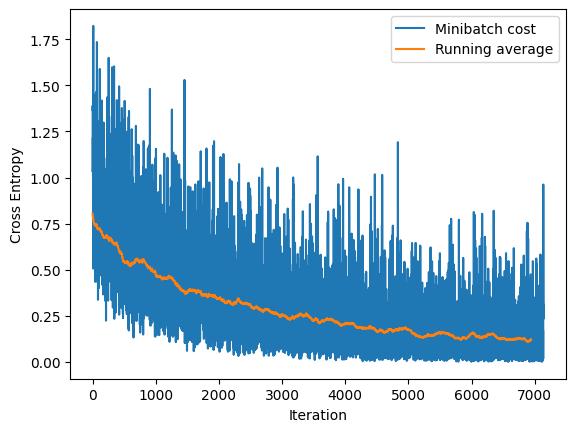

In [34]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

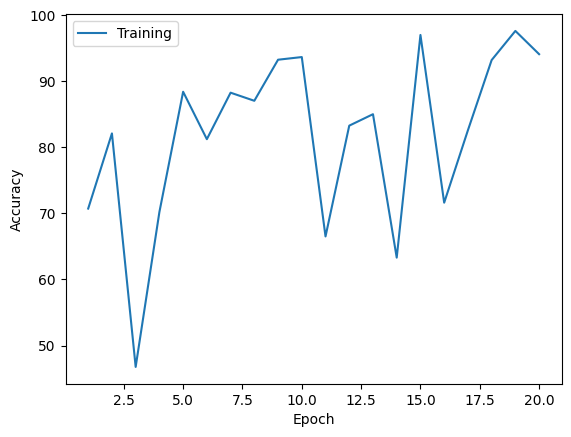

In [35]:
train_acc_list = [acc.cpu().numpy() for acc in train_acc_list]

plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
model = DenseNet121(num_classes=NUM_CLASSES, grayscale=GRAYSCALE).to(DEVICE)
model.load_state_dict(torch.load("densenet121_best.pt"))
with torch.set_grad_enabled(False):
    test_acc = compute_acc(model=model,
                           data_loader=test_loader,
                           device=DEVICE)
print(f'Test ACC: {test_acc:.2f}%')

/tmp/ipykernel_23/75206775.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("densenet121.pt"))


Test ACC: 94.05%
